In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))

    def forward(self, x, M):
        mu = self.get_mu()
        e  = self.get_e()
        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        return torch.abs(self.e_)
    
    def get_mu(self):
        return torch.abs(self.mu_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu()
        e  = self.get_e()

        dchi = torch.autograd.grad(chi, phi, 
                               grad_outputs=torch.ones_like(chi), 
                               create_graph=True,
                               allow_unused=True)[0]
        
        ddchi = torch.autograd.grad(dchi, 
                               phi, 
                               grad_outputs=torch.ones_like(dchi), 
                               create_graph=True)[0]
    

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        # L2 Loss
        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)
        
        loss1 *= lambda1
        loss2 *= lambda2

        return loss1 + loss2
    

class PPINN(nn.Module):
    def __init__(self, NPINNs=2, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()

        self.pinns = nn.ModuleList([])
        for i in range(NPINNs):
            self.pinns.append(PINN(in_chan, out_chan, chans))

        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))

    def get_M(self):
        return torch.abs(self.M_)    
    
    def forward(self, *phi):
        u = []

        for i, phi_ in enumerate(phi):
            u.append(self.pinns[i](phi_, M=self.get_M()))
    
        return u
        #M  = self.get_M()

    def physical_loss(self, *phi):
        loss = []

        for i, phi_ in enumerate(phi):
            loss.append(self.pinns[i].physical_loss(phi_))

        return loss

In [4]:
class chi2(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y, z):
        # x: predicted, y: target, z: error
        return torch.sum((x - y)**2/z)


class chiGINN(PPINN):
    def __init__(self, NPINNs, in_chan, out_chan, chans):
        super().__init__(NPINNs, in_chan, out_chan, chans)
    
    def forward(self, phi, mu_, M_, e_):
        u_ = []

        for i, phi_ in enumerate(phi):
            if i == 0:  # -> S2
                u = torch.abs(mu_)/M_ * (1 + torch.abs(e_) * torch.cos(self.pinns[i].nn(phi_)))
                u_.append(u)
            else:
                mu = self.pinns[i].get_mu()
                e = self.pinns[i].get_e()
                u = mu/M_ * (1 + e * torch.cos(self.pinns[i].nn(phi_)))
                u_.append(u)

        return u_

In [5]:
state = torch.load("states/PPINN1.pth")
model = chiGINN(NPINNs=len(state['stars']), in_chan=1, out_chan=1, chans=[8,8,8]).to(device)
model.load_state_dict(state['model'])
model.eval();

criterion = chi2()



from src.SLoader import SLoader
scaling = 1e-3


#loaders = []
stars = ["S2", "S38", "S1"]

phi = []
u = []
std = []

for star in stars:
    SL = SLoader(star=star, scaling=scaling)
    #print(star, len(SL))
    #loaders.append(SL)
    phi.append(SL.phi)
    u.append(SL.u)

    s_r = SL.u * (SL.x * SL.x_e + SL.y * SL.y_e)
    std.append(s_r)


u = torch.cat(u)
std = torch.cat(std).abs()

N = 25

/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/src/SLoader.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/src/SLoader.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/src/SLoader.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)


In [6]:
e_ = model.pinns[0].e_.item()
M_ = model.M_.item()
mu_ = model.pinns[0].mu_.item()

"""
e_ = torch.tensor(0.8839)
M_ = torch.tensor(0.0412)
mu_ = torch.tensor(0.1933)
"""

dl_e = 0.01 # vary with 10%
dl_M = 0.02
dl_mu = 0.02


e_arr = torch.linspace(e_*(1-dl_e), e_*(1+dl_e), steps=N)
M_arr = torch.linspace(M_*(1-dl_M), M_*(1+dl_M), steps=N)
mu_arr = torch.linspace(mu_*(1-dl_mu), mu_*(1+dl_mu), steps=N)

chi = torch.zeros((N,N,N))

"""
for i, e in tqdm(enumerate(e_arr)):
    for j, M in enumerate(M_arr):
        for k, mu in enumerate(mu_arr):
            u_ = model(phi, mu_=mu, M_=M, e_=e)
            u_ = torch.cat(u_)
            chi[i,j,k] = criterion(u_, u, std)
"""         


'\nfor i, e in tqdm(enumerate(e_arr)):\n    for j, M in enumerate(M_arr):\n        for k, mu in enumerate(mu_arr):\n            u_ = model(phi, mu_=mu, M_=M, e_=e)\n            u_ = torch.cat(u_)\n            chi[i,j,k] = criterion(u_, u, std)\n'

In [7]:
def chi(mu, M, e):
    u_ = model(phi, mu_=mu, M_=M, e_=e)
    u_ = torch.cat(u_)
    return criterion(1/u_, 1/u, std)

Nmcmc = 100_000
MCMCtable = []

old_e = torch.tensor(0.5) # 0.88
old_M = torch.tensor(0.1) # 0.04
old_mu = torch.tensor(0.3) # 0.18

old_chi = chi(old_mu, old_M, old_e)

de = 0.0007
dM = 0.00007
dmu = 0.0007

w = 1
for i in range(Nmcmc):
    if i % 10_000 == 0:
        print(i)

    new_e = torch.normal(old_e, de)
    new_M = torch.normal(old_M, dM)
    new_mu = torch.normal(old_mu, dmu)

    new_chi = chi(new_mu, new_M, new_e)

    rnd = torch.rand(1)
    if rnd < torch.exp((old_chi - new_chi)/2):
        MCMCtable.append([w, old_chi, old_mu, old_M, old_e])

        old_chi = new_chi
        old_e = new_e
        old_M = new_M
        old_mu = new_mu
        w = 1
    else:
        w += 1
        
        


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


Acceptance Ratio: 0.2089


tensor([[1.0440e+03, 4.3038e+06, 8.8433e-01],
        [1.0400e+03, 4.3068e+06, 8.8389e-01],
        [1.0407e+03, 4.3075e+06, 8.8364e-01],
        ...,
        [1.0449e+03, 4.3150e+06, 8.8416e-01],
        [1.0427e+03, 4.3072e+06, 8.8467e-01],
        [1.0411e+03, 4.3070e+06, 8.8458e-01]], dtype=torch.float64)

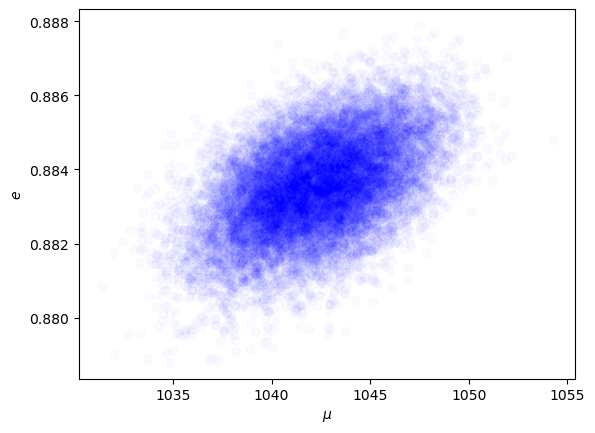

In [8]:
burn_in = 0.2 # remove first 10 %
table = torch.tensor(MCMCtable)[:,2:]

print(f"Acceptance Ratio: {len(table)/Nmcmc}") # should be ~ 0.2 


table = table[int(len(table)*burn_in):]

# transform mu into a 
table[:,0] = table[:,1]/(table[:,0]*(1 - table[:,2]**2)) * 1000

from astropy.constants import c, G

table[:,1] = 1.496e11 * table[:,1] * c.value**2 / G.value / 1.989e30 # AU to m, m to kg, kg to M_sol


plt.plot(table[:,0], table[:,-1], 'bo', alpha=0.02)
plt.xlabel(r"$\mu$"); plt.ylabel(r"$e$")
table

Removed no burn in


(980.0, 1070.0)

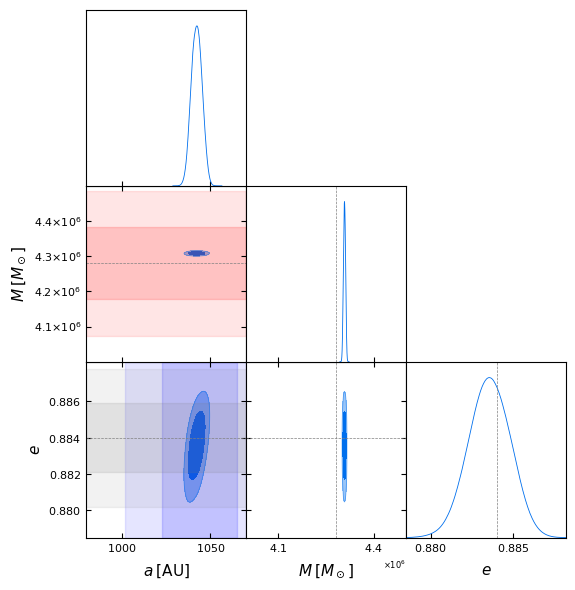

In [ ]:
import getdist
from getdist import plots, MCSamples

# a = M/(mu*(1-e**2))

names = [r"$a\:$[AU]", r"$M\:$[$M_\odot$]", r"$e$"]


samples = MCSamples(samples=table.numpy(), names=names)

g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True, 
    markers={
        names[0]: 970.,        # \pm 21
        names[1]: 4.280*1e6,    # \pm 0.103e6
        names[2]: 0.884},
    )       # \pm 0.0019

g.add_y_bands(4.280e6, 0.103e6, ax=[1,0], color="red")
g.add_x_bands(1044., 21, ax=[2,0], color="blue")
g.add_y_bands(0.884, 0.0019, ax=[2,0])

g.subplots[1,0].set_ylim(4.05e6, 4.5e6);
g.subplots[2,0].set_xlim(980, 1070)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert from "chi" (e.g. loss) to likelihood:
# Optional: normalize or exponentiate depending on interpretation
likelihood = torch.exp(-chi)  # if chi is loss-like
likelihood_np = likelihood.detach().numpy()

# Marginals
P_e = likelihood_np.sum(axis=(1,2))      # Marginal over M and mu
P_M = likelihood_np.sum(axis=(0,2))      # Marginal over e and mu
P_mu = likelihood_np.sum(axis=(0,1))     # Marginal over e and M

# 2D slices (joint)
P_eM = likelihood_np.sum(axis=2)         # Joint over e and M
P_emu = likelihood_np.sum(axis=1)        # Joint over e and mu
P_Mmu = likelihood_np.sum(axis=0)        # Joint over M and mu

# Normalize
P_e /= P_e.sum()
P_M /= P_M.sum()
P_mu /= P_mu.sum()
P_eM /= P_eM.sum()
P_emu /= P_emu.sum()
P_Mmu /= P_Mmu.sum()

# Create triangle plot manually
fig, axes = plt.subplots(3, 3, figsize=(10,10))

# Turn off unused plots
for i in range(3):
    for j in range(i+1, 3):
        axes[i, j].axis('off')

# 1D plots
axes[0,0].plot(e_arr.numpy(), P_e)
axes[1,1].plot(M_arr.numpy(), P_M)
axes[2,2].plot(mu_arr.numpy(), P_mu)

# 2D plots
e_grid, M_grid = torch.meshgrid(e_arr, M_arr, indexing='ij')
axes[1,0].contourf(e_grid.numpy(), M_grid.numpy(), P_eM, levels=25)
axes[2,0].contourf(e_grid.numpy(), mu_arr.numpy()[None,:]*np.ones_like(e_grid.numpy()), P_emu, levels=25)
axes[2,1].contourf(M_arr.numpy()[None,:]*np.ones_like(e_grid.numpy()), mu_arr.numpy()[:,None]*np.ones_like(M_arr.numpy()[None,:]), P_Mmu, levels=25)

# Label axes
axes[2,0].set_xlabel("e")
axes[1,0].set_ylabel("M")
axes[2,1].set_ylabel("mu")
axes[2,1].set_xlabel("M")
axes[2,2].set_xlabel("mu")

plt.tight_layout()
plt.show()

i,j,k = np.unravel_index(np.argmax(torch.exp(-chi).detach().numpy()), chi.shape)

print(e_arr[i])
print(M_arr[j])
print(mu_arr[k])


TypeError: bad operand type for unary -: 'function'

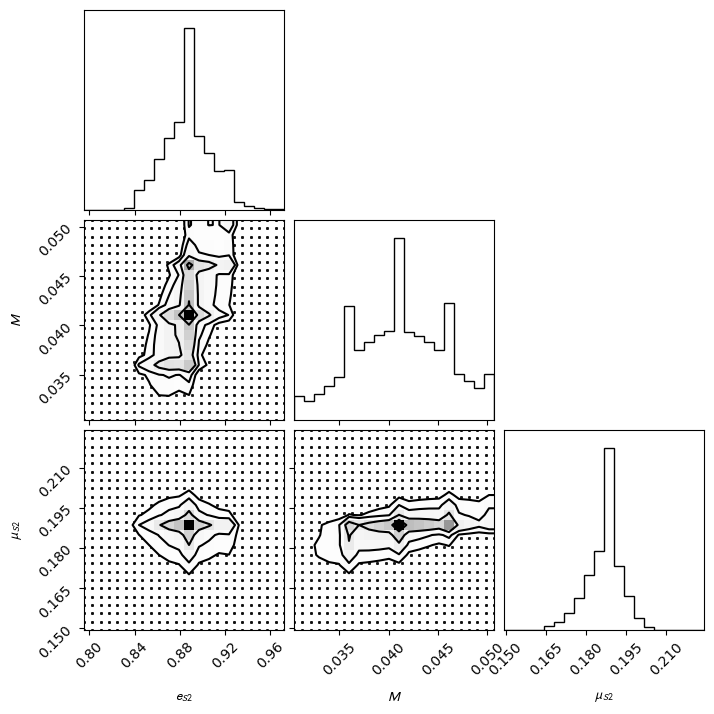

In [ ]:
import corner
samples = np.array(np.meshgrid(e_arr, M_arr, mu_arr)).T.reshape(-1, 3)
figure = corner.corner(samples, weights=torch.exp(-chi).detach().numpy().flatten(), labels=["$e_{S2}$", "$M$", "$\mu_{S2}$"])

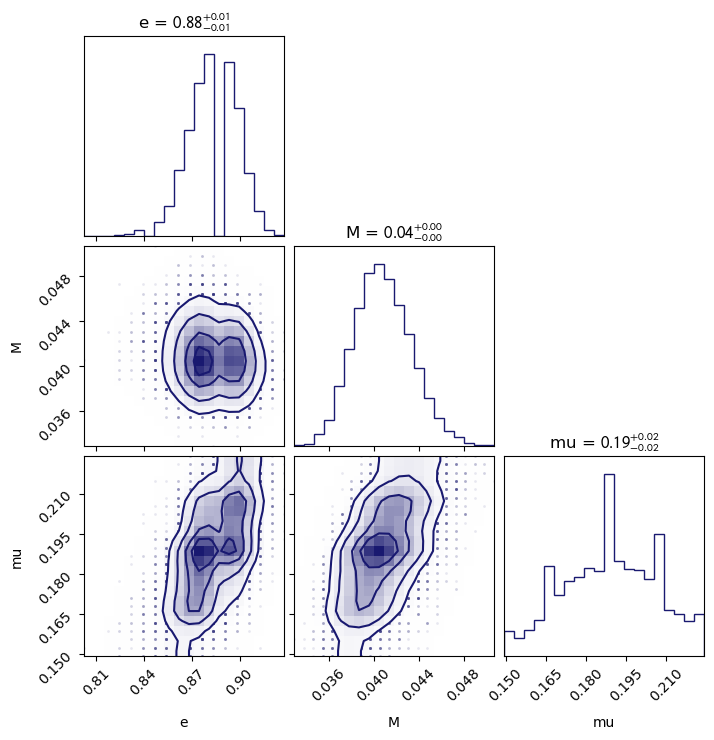

In [ ]:
likelihood = torch.exp(-chi)
likelihood_np = likelihood.detach().numpy()

# Create 3D meshgrid of parameter values
e_vals = e_arr.numpy()
M_vals = M_arr.numpy()
mu_vals = mu_arr.numpy()
E, M, MU = np.meshgrid(e_vals, M_vals, mu_vals, indexing='ij')

# Flatten everything to arrays
params = np.column_stack([E.ravel(), M.ravel(), MU.ravel()])
weights = likelihood_np.ravel()
weights /= weights.sum()  # Normalize weights

# Optionally sample points according to likelihood for corner plot
#n_samples = 10000
#indices = np.random.choice(len(weights), size=n_samples, p=weights)
#samples = params[indices]

# Plot with corner
figure = corner.corner(
    samples,
    labels=["e", "M", "mu"],
    bins=25,
    smooth=1.0,
    color="midnightblue",
    show_titles=True,
    title_fmt=".2f"
)

plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(samples, columns=["$e$", "$M$", "$\mu$"])
df["likelihood"] = torch.exp(-chi).detach().numpy().flatten()


g = sns.pairplot(
    df,
    kind="kde",
    vars=["$e$", "$M$", "$\mu$"],
    weights="likelihood",
    corner=True,
)

TypeError: pairplot() got an unexpected keyword argument 'weights'

In [ ]:
df

,$e$,$M$,$\mu$,likelihood
0,0.795277,0.030402,0.149353,9.128702e-24
1,0.795277,0.031246,0.149353,8.342836e-26
2,0.795277,0.032091,0.149353,5.737306e-28
3,0.795277,0.032935,0.149353,2.969033e-30
4,0.795277,0.033780,0.149353,1.156214e-32
...,...,...,...,...
15620,0.972006,0.047292,0.224030,2.278955e-16
15621,0.972006,0.048136,0.224030,4.651454e-16
15622,0.972006,0.048981,0.224030,9.220715e-16
15623,0.972006,0.049825,0.224030,1.775279e-15


In [ ]:
i,j,k = np.unravel_index(np.argmax(torch.exp(-chi).detach().numpy()), chi.shape)

print(e_arr[i])
print(M_arr[j])
print(mu_arr[k])


# v1
# e_ = torch.tensor(0.8839)
# M_ = torch.tensor(0.0412)
# mu_ = torch.tensor(0.1933)

# v2
# tensor(0.8836)
# tensor(0.0405)
# tensor(0.1867)


tensor(0.8836)
tensor(0.0405)
tensor(0.1867)
